In [5]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping


import warnings 

warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [6]:
df=pd.read_csv("/TSLA.csv")

In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [8]:
def check_df(dataframe,head=5):
  print("########### shape ###########")
  print(dataframe.shape)
  print("########### types ###########")
  print(dataframe.dtypes)
  print("########### types ###########")
  print(dataframe.head(head))
  print("########### types ###########")
  print(dataframe.tail(head))
  print("########### types ###########")
  print(dataframe.isnull().sum())
  print("########### types ###########")
  print(dataframe.quantile([0,0.05,0.50,0.95,0.99,0.1]).T)

In [9]:
check_df(df)

########### shape ###########
(2416, 7)
########### types ###########
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
########### types ###########
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
########### types ###########
            Date        Open        High         Low       Close   Adj Close  \
2411  2020-01-28  568.489990  576.809998  558.080017  566.900024  566.900024   
2412  2020-01-29  575.690002  589.799988  567.429993  580.989990  580.989990   
2413  2020-01-30  6

In [10]:

df["Date"]=pd.to_datetime(df["Date"])


In [11]:
tesla_df=df[["Date","Close"]]
tesla_df["Date"]=pd.to_datetime(tesla_df["Date"])

In [12]:
tesla_df.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [13]:
tesla_df.index=tesla_df["Date"]
tesla_df

,Date,Close
Date,,
2010-06-29,2010-06-29,23.889999
2010-06-30,2010-06-30,23.830000
2010-07-01,2010-07-01,21.959999
2010-07-02,2010-07-02,19.200001
2010-07-06,2010-07-06,16.110001
...,...,...
2020-01-28,2020-01-28,566.900024
2020-01-29,2020-01-29,580.989990
2020-01-30,2020-01-30,640.809998


In [14]:
tesla_df.drop("Date", axis=1, inplace=True)

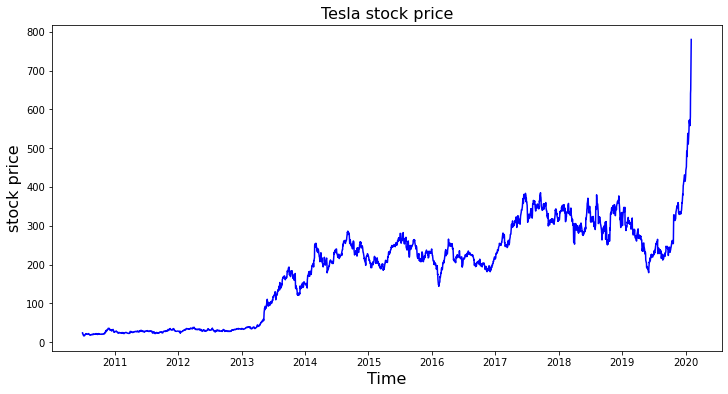

In [15]:
result_df=tesla_df.copy()
plt.figure(figsize=(12,6))

plt.plot(tesla_df['Close'], color='blue')
plt.xlabel('Time',fontsize=16)
plt.ylabel('stock price',fontsize=16)
plt.title('Tesla stock price',fontsize=16)
plt.show()

In [16]:
tesla_df=tesla_df.values
tesla_df=tesla_df.astype('float32')

In [17]:
def split_data(dataframe,test_size):
  pos=int(round(len(dataframe)*(1-test_size)))
  train=dataframe[:pos]
  test=dataframe[pos:]
  return train,test,pos

In [18]:
train,test,pos=split_data(tesla_df,0.20)
print(train.shape,test.shape)

(1933, 1) (483, 1)


In [19]:
scaler_train=MinMaxScaler(feature_range=(0,1))
train=scaler_train.fit_transform(train)
scaler_test=MinMaxScaler(feature_range=(0,1))
test=scaler_test.fit_transform(test)

In [20]:
def create_features(data,lookback):
  X,Y=[],[]
  for i in range(lookback,len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  
  return np.array(X),np.array(Y)
lookback=20  

In [21]:
X_train,y_train=create_features(train,lookback)
X_test,y_test=create_features(test,lookback)

In [23]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

In [22]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1913, 20) (1913,) (463, 20) (463,)


In [24]:
model=Sequential()
model.add(LSTM(units=50,
               activation='relu',
               input_shape=(X_train.shape[1],lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss='mean_squared_error',optimizer='adam')
callbacks=[EarlyStopping(monitor='val_loss',patience=3,verbose=1,mode="min"),
           ModelCheckpoint(filepath='mymodel.h5',monitor='val_loss',mode='min',
           save_best_only=True,save_weights_only=False,verbose=1)]

In [27]:
history=model.fit(x=X_train,
                  y=y_train,
                  epochs=100,
                  batch_size=20,
                  validation_data=(X_test,y_test),
                  callbacks=callbacks,
                  shuffle=False)

Epoch 1/100
94/96 [============================>.] - ETA: 0s - loss: 0.0065
Epoch 1: val_loss improved from inf to 0.00405, saving model to mymodel.h5
96/96 [==============================] - 3s 11ms/step - loss: 0.0066 - val_loss: 0.0040
Epoch 2/100
96/96 [==============================] - ETA: 0s - loss: 0.0058
Epoch 2: val_loss improved from 0.00405 to 0.00308, saving model to mymodel.h5
96/96 [==============================] - 1s 6ms/step - loss: 0.0058 - val_loss: 0.0031
Epoch 3/100
92/96 [===========================>..] - ETA: 0s - loss: 0.0043
Epoch 3: val_loss improved from 0.00308 to 0.00280, saving model to mymodel.h5
96/96 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0028
Epoch 4/100
88/96 [==========================>...] - ETA: 0s - loss: 0.0034
Epoch 4: val_loss improved from 0.00280 to 0.00252, saving model to mymodel.h5
96/96 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 5/100
89/96 [================

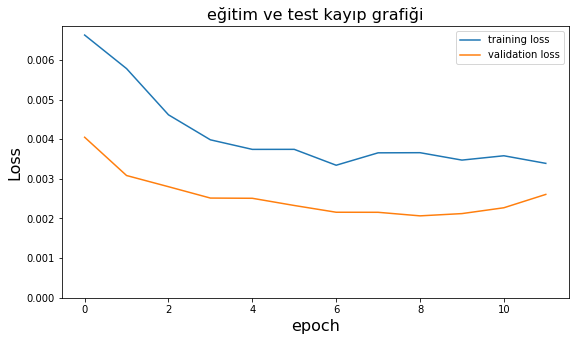

In [28]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.legend(loc='upper right')
plt.xlabel('epoch',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('eğitim ve test kayıp grafiği',fontsize=16)
plt.show()

In [29]:
loss=model.evaluate(X_test,y_test,batch_size=20)
print("\n Test Loss: %.1f%%" % (100.0*loss))

24/24 [==============================] - 0s 2ms/step - loss: 0.0026

 Test Loss: 0.3%


In [30]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

15/15 [==============================] - 0s 2ms/step


In [31]:
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)

In [32]:
y_train=scaler_train.inverse_transform(y_train)
y_test=scaler_test.inverse_transform(y_test)

In [33]:
train_rmse=np.sqrt(mean_squared_error(y_train,train_predict))
test_rmse=np.sqrt(mean_squared_error(y_test,test_predict))


In [34]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 13.196410179138184
Test RMSE: 30.689937591552734


In [35]:
train_prediction_df=result_df[lookback:pos]
train_prediction_df["Predicted"]=train_predict
train_prediction_df.head()

,Close,Predicted
Date,,
2010-07-28,20.719999,34.957478
2010-07-29,20.350000,34.949322
2010-07-30,19.940001,34.966827
2010-08-02,20.920000,34.999714
2010-08-03,21.950001,34.995380


In [36]:
test_prediction_df=result_df[lookback+pos:]
test_prediction_df["Predicted"]=test_predict
test_prediction_df.head()

,Close,Predicted
Date,,
2018-04-03,267.529999,319.651550
2018-04-04,286.940002,316.766113
2018-04-05,305.720001,314.677185
2018-04-06,299.299988,315.824280
2018-04-09,289.660004,317.132416


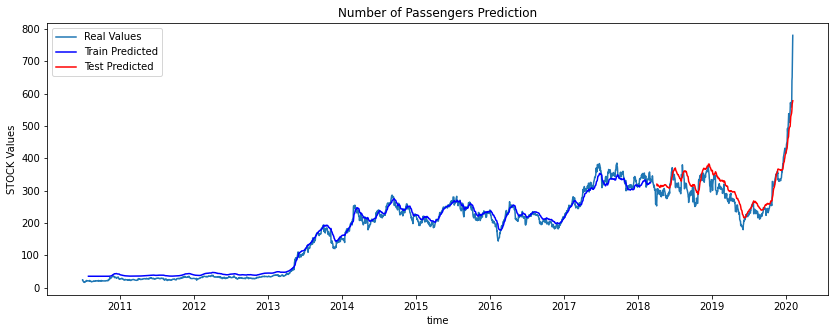

In [37]:
plt.figure(figsize=(14,5))
plt.plot(result_df,label='Real Values')
plt.plot(train_prediction_df["Predicted"],color='blue', label='Train Predicted')
plt.plot(test_prediction_df["Predicted"],color='red', label='Test Predicted')
plt.title('Number of Passengers Prediction')
plt.xlabel('time')
plt.ylabel('STOCK Values')
plt.legend()
plt.show()